<a href="https://colab.research.google.com/github/paulcodrea/dissertation/blob/main/7_LSTM_prediction_BTC_price_and_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install wandb

In [15]:
!wandb login
# cb34a0b023a44c8d62a2d3cefe662c5437f3e003

wandb: Currently logged in as: paulcodrea (use `wandb login --relogin` to force relogin)


In [16]:
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import tensorflow as tf
import wandb
from wandb.keras import WandbCallback
from time import time
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LSTM
# from keras.optimizers import Adam
from time import time
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [17]:
wandb.init(project="7_LSTM-precition_BTC_price-and-sentiment", entity="paulcodrea")

In [18]:
wandb.config = {
    "learning_rate": 0.001, 
    "epochs": 70, 
    "batch_size": 2,
    "training_index": 0.55, 
    "validation_index": 0.05, 
    "layer_1": 50, 
    "layer_2": 100,
    # "timesteps": 2,
}

In [19]:
# df = pd.read_csv('/content/drive/MyDrive/COMP30030_Dissertation_paul.codrea/Market-prediction/final_price-and-compund.csv', parse_dates=True, index_col="date")

df = pd.read_csv('/content/drive/MyDrive/COMP30030_Dissertation_paul.codrea/Market-prediction/final_price-and-score.csv', parse_dates=True, index_col="date")
df = df[['score', 'close']]
print(df.head())

                            score     close
date                                       
2022-02-27 11:00:00  1.830000e-07  39506.94
2022-02-27 12:00:00  3.000000e-06  39772.65
2022-02-27 13:00:00  4.040000e-07  39087.32
2022-02-27 14:00:00  4.840000e-07  38805.72
2022-02-27 15:00:00  1.170000e-06  39375.33


In [20]:
# Data normalization. This is one of the first steps to normalize the values. 
# The goal is to change the values of numeric columns in the data set to a common scale, wihtout distorting differeces in the randes of values. 
df_values = df.values
sc = MinMaxScaler()
data_scaled = sc.fit_transform(df_values)

# print(len(data_scaled))
# print(data_scaled.size)
# print(data_scaled)

In [21]:
# Splitting data into training and testing data 

train_index = int(wandb.config['training_index'] * len(data_scaled))
val_index = train_index + int(wandb.config['validation_index'] * len(data_scaled))

train = data_scaled[:train_index]
val = data_scaled[train_index:val_index]
test = data_scaled[val_index:]

In [22]:
print("train,test,val",train.shape, test.shape, val.shape)

train,test,val (100, 2) (73, 2) (9, 2)


In [23]:
xtrain, ytrain = train[:,:2], train[:,1]
xtest, ytest = test[:,:2], test[:,1]
xval, yval = val[:,:2], val[:,1]


# # Get xtrain and ytrain
# xtrain, ytrain = train[:, :6], train[:, 4]
# # Get xtest and ytest
# xtest, ytest = test[:, :6], test[:, 4]
# # Get xval and yval
# xval, yval = val[:, :6], val[:, 4]

In [24]:
lookback = 2 # xtrain.shape[1]
n_features = 2
train_len = len(xtrain) - lookback
test_len = len(xtest) - lookback
val_len = len(xval) - lookback

print("Train len:", train_len)
print("Test len:", test_len)

x_train = np.zeros((train_len, lookback, n_features))
y_train = np.zeros((train_len))
for i in range(train_len):
    ytemp = i+lookback
    x_train[i] = xtrain[i:ytemp]
    y_train[i] = ytrain[ytemp]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_test = np.zeros((test_len, lookback, n_features))
y_test = np.zeros((test_len))
for i in range(test_len):
    ytemp = i+lookback
    x_test[i] = xtest[i:ytemp]
    y_test[i] = ytest[ytemp]
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_val = np.zeros((val_len, lookback, n_features))
y_val = np.zeros((val_len))
for i in range(val_len):
    ytemp = i+lookback
    x_val[i] = xval[i:ytemp]
    y_val[i] = yval[ytemp]
print("x_val", x_val.shape)
print("y_val", y_val.shape)

model = Sequential()  
model.add(LSTM(wandb.config['layer_1'],input_shape = (lookback, n_features), return_sequences=True, activation='tanh'))
model.add(Dropout(0.15))
model.add(LSTM(wandb.config['layer_2'], activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
print(model.summary())

model.compile(loss = 'mse', optimizer = 'adam')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

start = time()
print("start:",0)
history = model.fit(x_train,y_train, epochs = wandb.config['epochs'], batch_size=wandb.config['batch_size'], 
          validation_data=(x_val,y_val),verbose = 1, 
          shuffle = False, callbacks=[WandbCallback(), earlystop])

# Print the time it took to run the code
print("Time: %.4f" % (time() - start))

Train len: 98
Test len: 71
x_train (98, 2, 2)
y_train (98,)
x_test (71, 2, 2)
y_test (71,)
x_val (7, 2, 2)
y_val (7,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 50)             10600     
                                                                 
 dropout (Dropout)           (None, 2, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 71,101
Trainable params: 71,101
Non-trainable params: 0


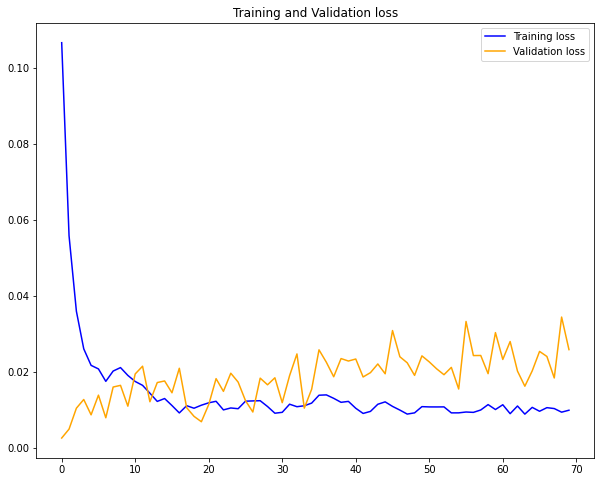

MSE: 0.0573
RMSE: 0.2395
MAE: 0.1952
MAPE (percentage): 83.9814


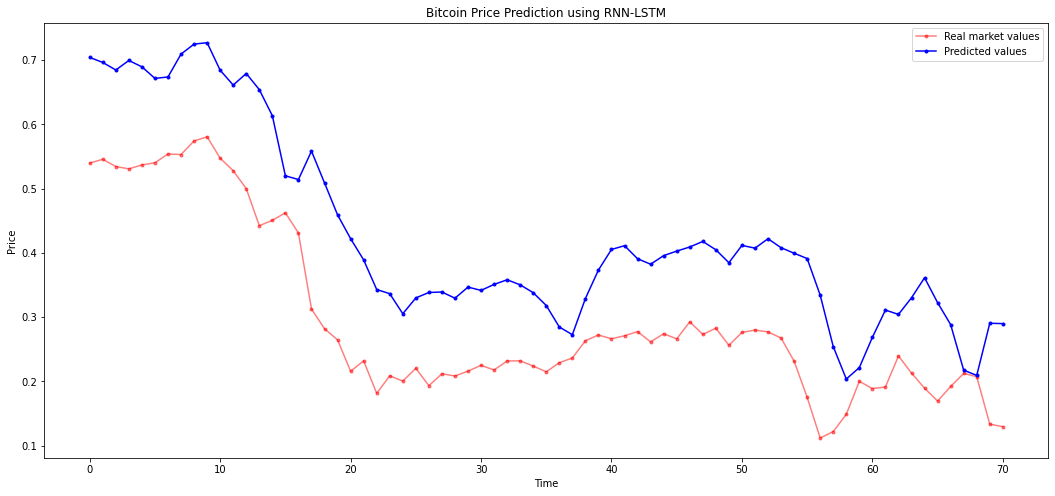

In [29]:
# Plotting data 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 8))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title("Training and Validation loss")
plt.legend()
plt.show()

# Predict the model
y_pred = model.predict(x_test)

# Print out Mean Squared Error (MSE)
mse = np.mean((y_pred - y_test)**2)
print("MSE: %.4f" % mse)

# Print out Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("RMSE: %.4f" % rmse)

# Print out Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_pred - y_test))
print("MAE: %.4f" % mae)

# Print out Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print("MAPE (percentage): %.4f" % mape)

# Invers Scaling 
# actual_inverse = sc.inverse_transform([y_test])
# actual_inverse_2d = np.reshape(actual_inverse, (actual_inverse.shape[1], 1))
# pred_inverse = sc.inverse_transform(y_pred)

plt.figure(figsize=(18,8))
plt.plot(y_test, '.-', color='red', label='Real market values', alpha=0.5)
plt.plot(y_pred, '.-', color='blue', label='Predicted values', alpha=1)
plt.title("Bitcoin Price Prediction using RNN-LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

## Cross-correlation analysis
The correlation coefficient is measured on a scale from -1 to 1. A correlation coefficient of 1 indicates a perfect positive correlation between the prices of two stocks, meaning the stocks always move in the same direction by the same amount. A coefficient of -1 indicates a perfect negative correlation, meaning that the stocks have historically always moved in the opposite direction. If two stocks have a correlation coefficient of 0, it means there is no correlation and, therefore, no relationship between the stocks. It is unusual to have either a perfect positive or negative correlation.

In [30]:
actual_price = pd.DataFrame(y_test, columns=['price'])
predicted_price = pd.DataFrame(y_pred, columns=['price'])

In [31]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method=method)

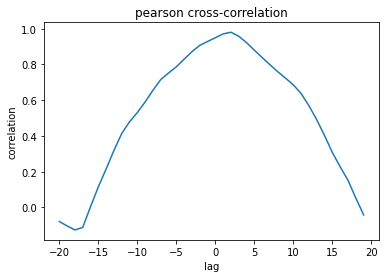

In [32]:
xcov = [crosscorr(predicted_price['price'], actual_price['price'], lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

In [34]:
actual_price['price'].corr(predicted_price['price'])

0.9499323120784195